This notebook loads the unfiltered unwrapped igrams, makes some time series between a few pairs of points, and then with 10x10 clusters of pixels.

This notebook: <br>
1. loads in unfiltered, unwrapped igrams 
2. extracts time series between a pair of points, plots it
3. extracts clusters of time series between pairs from 10x10 areas
4. plots 1sigma above - 1sigma below median 

This notebook was written on 1-30-23

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Read in unfiltered, unwrapped igrams. Can take a few minutes.

In [2]:
# igramsDir is where the cropped, unwrapped igrams are 
igramsDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
igramsDir2 = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/filt_unwrapped/'
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')
unwr_filt = np.ndarray((numIgrams,dy,dx),dtype='float')
# loop through the dates 
for i in range(numIgrams): # numIgrams if doing all of them at once
    date1=dates[i]
    date2=dates[i+1]
    igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    igramFile = igramsDir2+date1+'_'+date2+'_filt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    unwr_filt[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
print('unfiltered unwrapped igrams loaded.')
print('filtered unwrapped igrams loaded.')

unfiltered unwrapped igrams loaded.
filtered unwrapped igrams loaded.


Optional: Plot a sample interferogram with a box around a potential reference area.

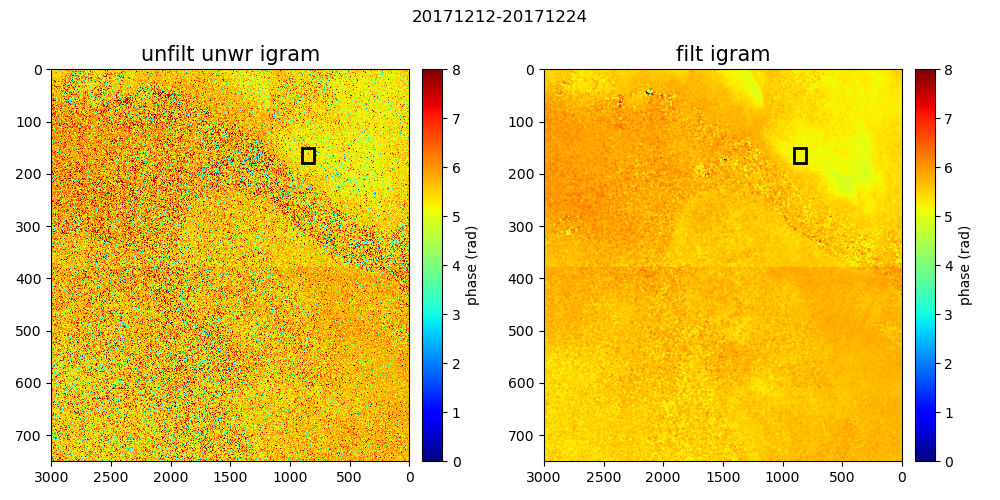

In [3]:
#k = 15 # which igram to plot? 
k = 59
k = 17
date1 = dates[k]; date2 = dates[k+1]
plt.figure(figsize=(10,5),tight_layout=True) 
plt.subplot(1,2,1)
plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=0,vmax=8)
#plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=-3,vmax=4)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([]) # this takes xlabels and ylabels away 
plt.title('unfilt unwr igram',fontsize=15)
# add another box for the area I'll use as the reference region later. 
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.subplot(1,2,2)
plt.imshow(unwr_filt[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=0,vmax=8)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('filt igram',fontsize=15)
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.suptitle(str(date1)+'-'+str(date2))
plt.show()
#plt.savefig("sample_igram_1_AGU.png", transparent=True)

Define two points: a point in LS and a point in open desert. One is considered a reference point because it's all relative.

In [4]:
key = 3
#refpoint = [0,2999] # ref point as upper left corner pixel 
if key==0:
    refpoint = [500,2500]      # a, purple     # ref point as open desert 
    comparepoint = [500,1000]  # b, purple 
elif key==1:
    refpoint = [500,2200]      # c, orange
    comparepoint = [300,1500]  # d, orange
elif key==2:
    refpoint = [400,2200]      # e, green 
    comparepoint = [350,1500]  # f, green 
elif key==3:
    refpoint = [645,2000]      # g, blue 
    comparepoint = [645,1000]  # h, blue 
else:
    print('choose ref and compare points by selecting a key 0-3.')

Pull out the time series for the one point relative to the reference point

In [5]:
# initialize arrays to hold time series for each point
dim_pixel_range = 10
num_pixels = int(dim_pixel_range**2)

disp_rates = np.zeros((numIgrams,num_pixels),dtype='float')
disp_rates_filt = np.zeros((numIgrams,num_pixels),dtype='float')
count = 0
# these are rates in (radians/igram interval)
for j in range(dim_pixel_range):
    for k in range(dim_pixel_range):
        # making sure to subtract off the reference point 
        disp_rates[:,count] = unwr_full_res[:,comparepoint[0]+j,comparepoint[1]+k] - unwr_full_res[:,refpoint[0]+j,refpoint[1]+k]
        disp_rates_filt[:,count] = unwr_filt[:,comparepoint[0]+j,comparepoint[1]+k] - unwr_filt[:,refpoint[0]+j,refpoint[1]+k]
        count += 1
# calculate cumulative displacement in radians 
cum_disps = np.cumsum(disp_rates,axis=0) # this and next are cumulative disp in (rad)
cum_disps_filt = np.cumsum(disp_rates_filt,axis=0)

Pull out dates in order to plot the time series

In [6]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# take numIgrams and pull out the igram_dates, corresponding to the first day of each igram
igram_dates = slc_dates[1::] # using second SLC date as the igram date, per Rowena's suggestion
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt = np.zeros([len(dt1),1])
for i in range(len(dt)):
    dt[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
print('slc_dates: '+str(np.shape(slc_dates)))
print('igram_dates: '+str(np.shape(igram_dates)))
print('^datetime objects now')
#print(dt)

slc_dates: (211,)
igram_dates: (210,)
^datetime objects now


Load precip data to plot vertical lines where big (>threshhold) storms occurred

In [7]:
# Read in 2day precipitation data
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')
#precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_cumulative.txt', dtype='float')

# BIGGER STORMS
# days with precip > 0.3cm 
#print('i \tdate \t\t       precip > 0.3cm')
print('i \tdate \t\t       precip > 0.0cm')
rain_dates = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.0:
        print(str(i)+'\t'+str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])

i 	date 		       precip > 0.0cm
0	2017-05-10 00:00:00    0.33020000000000005 cm
47	2018-12-07 00:00:00    5.0546 cm
55	2019-03-13 00:00:00    0.0762 cm
59	2019-05-12 00:00:00    0.10160000000000001 cm
74	2019-09-27 00:00:00    1.4478 cm
83	2019-11-20 00:00:00    2.286 cm
86	2019-12-08 00:00:00    0.254 cm
97	2020-02-12 00:00:00    1.1684 cm
102	2020-03-13 00:00:00    0.40640000000000004 cm
103	2020-03-19 00:00:00    0.254 cm
107	2020-04-12 00:00:00    0.9906 cm
154	2021-01-25 00:00:00    0.0762 cm
186	2021-08-11 00:00:00    0.381 cm


Now out of all the time series we produced, get values for each time of 1 sigma above median and 1 sigma below median to represent the spread of the data. Calculates which data is 1sigma above+below the median using the sorted list and the 68th percentile (34th above median, 34th below median).

In [8]:
# calculate time series for one standard deviation above median, one below median 
upper = np.zeros((len(igram_dates),)); upper_cum = np.zeros((len(igram_dates),)); median = np.zeros((len(igram_dates),))
lower = np.zeros((len(igram_dates),)); lower_cum = np.zeros((len(igram_dates),)); median_cum = np.zeros((len(igram_dates),))

upper_filt = np.zeros((len(igram_dates),)); upper_cum_filt = np.zeros((len(igram_dates),)); median_filt = np.zeros((len(igram_dates),))
lower_filt = np.zeros((len(igram_dates),)); lower_cum_filt = np.zeros((len(igram_dates),)); median_cum_filt = np.zeros((len(igram_dates),))

single_date_disps = np.zeros((num_pixels,)); single_date_cum_disps = np.zeros((num_pixels,))
single_date_disps_filt = np.zeros((num_pixels,)); single_date_cum_disps_filt = np.zeros((num_pixels,))
# make indices that line up to the 1sigma above and below the median:
above_index = int(num_pixels*0.5+0.34135*num_pixels)
below_index = int(num_pixels*0.5-0.34135*num_pixels)
median_index = int(num_pixels*0.5)
print('index of data point 1\u03C3 above median: '+str(above_index))
print('index of data point 1\u03C3 below median: '+str(below_index))
print('index of median data point: '+str(median_index))
# loop through each igram date
for i in range(len(igram_dates)): #len(igram_dates)
    # sort the values 
    single_date_disps = sorted(disp_rates[i,:])
    single_date_disps_filt = sorted(disp_rates_filt[i,:])
    #print(single_date_disps[0],single_date_disps[-1])
    upper[i] = single_date_disps[above_index]; upper_filt[i] = single_date_disps_filt[above_index]
    lower[i] = single_date_disps[below_index]; lower_filt[i] = single_date_disps_filt[below_index]
    median[i] = single_date_disps[median_index]; median_filt[i] = single_date_disps_filt[median_index]
    single_date_cum_disps = sorted(cum_disps[i,:]); single_date_cum_disps_filt = sorted(cum_disps_filt[i,:])
    upper_cum[i] = single_date_cum_disps[above_index]; upper_cum_filt[i] = single_date_cum_disps_filt[above_index]
    lower_cum[i] = single_date_cum_disps[below_index]; lower_cum_filt[i] = single_date_cum_disps_filt[below_index]
    median_cum[i] = single_date_cum_disps[median_index]; median_cum_filt[i] = single_date_cum_disps_filt[median_index]
#print(np.shape(disp_rates))
#print(np.shape(cum_disps))

index of data point 1σ above median: 84
index of data point 1σ below median: 15
index of median data point: 50


Plot the time series with vertical lines for storms (>threshold precip) and 1sigma above+below the median, with median also.

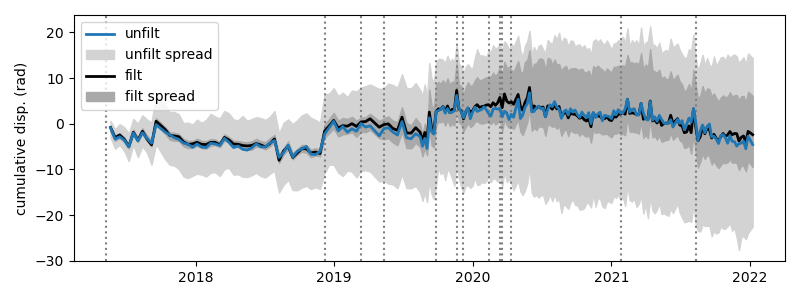

In [13]:
plt.figure(figsize=(8,3),tight_layout='TRUE')
# plt.subplot(1,2,1)
# plt.plot(igram_dates,median)
# plt.fill_between(igram_dates,lower,upper,color='lightgray')
# Ymin,Ymax = plt.gca().get_ylim()
# plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
# plt.ylim([Ymin,Ymax])
# #plt.legend(); 
# plt.title('Disp. rate at '+str(num_pixels)+' pixels (rad/igram)')
# plt.ylabel('disp. rate (radians/igram period)'); plt.xlabel('date')

#plt.subplot(1,2,2)
if key==0:
    color_to_use = 'purple'
elif key==1:
    color_to_use = 'tab:orange'
elif key==2:
    color_to_use = 'tab:green'
elif key==3:
    color_to_use = 'tab:blue'
plt.plot(igram_dates,median_cum,color=color_to_use,linewidth=2,label='unfilt',zorder=15) # purple,tab:orange,tab:green,tab:blue
plt.fill_between(igram_dates,lower_cum,upper_cum,color='lightgray',label='unfilt spread',zorder=0)
plt.plot(igram_dates,median_cum_filt,color='k',linewidth=2,label='filt',zorder=10)
plt.fill_between(igram_dates,lower_cum_filt,upper_cum_filt,color='darkgray',label='filt spread',zorder=1)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.legend(); 
#plt.title('Cum. disp. btw sets of '+str(num_pixels)+' pixels (rad)')
plt.ylabel('cumulative disp. (rad)'); #plt.xlabel('date')
plt.show()
#plt.savefig("time_series_g-h.pdf", transparent=True)

Convert to cm 

In [12]:
# make a conversion factor from radians to cm 
wavelength = 5.5465763
rad2cm = wavelength/(4*np.pi) # this is conversion factor that I multiply by the data (which is in rads)

median_cum_cm = median_cum*rad2cm; median_cum_filt_cm = median_cum_filt*rad2cm
lower_cum_cm = lower_cum*rad2cm; lower_cum_filt_cm = lower_cum_filt*rad2cm
upper_cum_cm = upper_cum*rad2cm; upper_cum_filt_cm = upper_cum_filt*rad2cm
print('cumulative displacements converted to cm.')

# convert 2pi radians to cm 
twoPi_interval_cm = np.pi*2*rad2cm
print('2\u03C0 radians = '+str(twoPi_interval_cm)+' cm')

cumulative displacements converted to cm.
2π radians = 2.77328815 cm


Now plot the same plot but in cm now (instead of radians like before) and plot horizontal lines where 2pi radian jumps exist

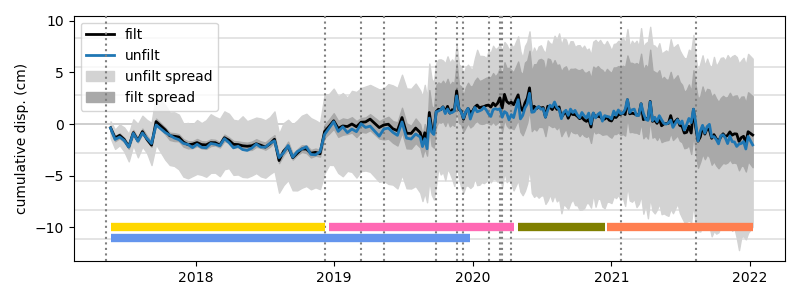

In [13]:
plt.figure(figsize=(8,3),tight_layout='TRUE')
if key==0:
    color_to_use = 'purple'
elif key==1:
    color_to_use = 'tab:orange'
elif key==2:
    color_to_use = 'tab:green'
elif key==3:
    color_to_use = 'tab:blue'
plt.plot(igram_dates,median_cum_filt_cm,color='k',linewidth=2,label='filt',zorder=15)
plt.plot(igram_dates,median_cum_cm,color=color_to_use,linewidth=2,label='unfilt',zorder=20) # purple,tab:orange,tab:green,tab:blue
plt.fill_between(igram_dates,lower_cum_cm,upper_cum_cm,color='lightgray',label='unfilt spread',zorder=5)
plt.fill_between(igram_dates,lower_cum_filt_cm,upper_cum_filt_cm,color='darkgray',label='filt spread',zorder=8)
Ymin,Ymax = plt.gca().get_ylim()
# calculate btw Ymin and Ymax where the 2pi rad multiples are
grid_multiples = []
count1 = 0
while (count1*twoPi_interval_cm < Ymax):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1+=1
count1 = 0
while (count1*twoPi_interval_cm > Ymin):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1-=1
#print(grid_multiples)
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=10)
Xmin,Xmax = plt.gca().get_xlim()
plt.hlines(grid_multiples,Xmin,Xmax,'gray',linewidth=0.3,zorder=0)
plt.ylim([Ymin,Ymax]); plt.xlim([Xmin,Xmax]); 
#plt.title('Cum. disp. btw sets of '+str(num_pixels)+' pixels (cm)')
plt.ylabel('cumulative disp. (cm)'); #plt.xlabel('date')
yval = -10.0
linewid = 6.0
plt.hlines(yval,igram_dates[0],igram_dates[46],color='gold',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[47],igram_dates[107],color='hotpink',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[108],igram_dates[146],color='olive',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[147],igram_dates[-1],color='coral',linewidth=linewid,zorder=10)
plt.hlines(yval-1.0,igram_dates[0],igram_dates[88],color='cornflowerblue',linewidth=linewid,zorder=10)
plt.legend()
plt.show()
#plt.savefig("time_series_g-h_with_time_blocks.pdf", transparent=True)

In [14]:
for i in np.arange(65,75,1):
    print(i,igram_dates[i], median_cum_cm[i])
# igram 70, 2019-09-03 has the largest permanent jump in disp. 

65 2019-08-04 00:00:00 -0.9649144070661391
66 2019-08-16 00:00:00 -1.2521224705427414
67 2019-08-22 00:00:00 -2.1803538199137282
68 2019-08-28 00:00:00 -1.4101071838834067
69 2019-09-03 00:00:00 -2.3934758936321843
70 2019-09-09 00:00:00 0.5760644309789785
71 2019-09-15 00:00:00 -0.7731412095784721
72 2019-09-21 00:00:00 -1.0069207210982634
73 2019-09-27 00:00:00 1.1883466637906277
74 2019-10-03 00:00:00 1.2608781950462036


Plot the difference between 1sigma above median and 1sigma below median over time with vertical lines for rain events. Does it sharply increase at precip timing?

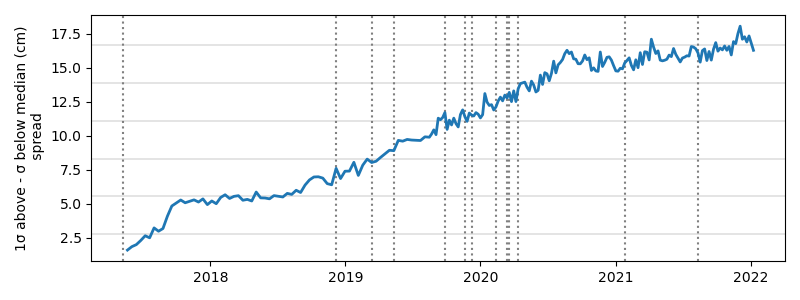

In [15]:
plt.figure(figsize=(8,3),tight_layout='TRUE')
if key==0:
    color_to_use = 'purple'
elif key==1:
    color_to_use = 'tab:orange'
elif key==2:
    color_to_use = 'tab:green'
elif key==3:
    color_to_use = 'tab:blue'
plt.plot(igram_dates,upper_cum_cm-lower_cum_cm,color=color_to_use,linewidth=2,zorder=30) # purple,tab:orange,tab:green,tab:blue
Ymin,Ymax = plt.gca().get_ylim()
# calculate btw Ymin and Ymax where the 2pi rad multiples are
grid_multiples = []
count1 = 0
while (count1*twoPi_interval_cm < Ymax):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1+=1
count1 = 0
while (count1*twoPi_interval_cm > Ymin):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1-=1
#print(grid_multiples)
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=20)
Xmin,Xmax = plt.gca().get_xlim()
plt.hlines(grid_multiples,Xmin,Xmax,'gray',linewidth=0.3,zorder=0)
plt.ylim([Ymin,Ymax]); 
plt.xlim([Xmin,Xmax])
#plt.title('Cumulative disp. at '+str(num_pixels)+' pixels (rad/igram)')
plt.ylabel('1\u03C3 above - \u03C3 below median (cm)\n spread'); #plt.xlabel('date')

plt.show()
#plt.savefig("time_series_g-h_with_time_blocks.pdf", transparent=True)

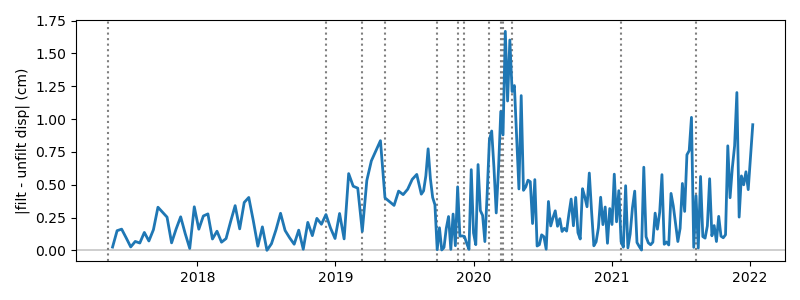

In [16]:
plt.figure(figsize=(8,3),tight_layout='TRUE')
if key==0:
    color_to_use = 'purple'
elif key==1:
    color_to_use = 'tab:orange'
elif key==2:
    color_to_use = 'tab:green'
elif key==3:
    color_to_use = 'tab:blue'
plt.plot(igram_dates,np.abs(median_cum_filt_cm-median_cum_cm),color=color_to_use,linewidth=2,zorder=15)
Ymin,Ymax = plt.gca().get_ylim()
# calculate btw Ymin and Ymax where the 2pi rad multiples are
grid_multiples = []
count1 = 0
while (count1*twoPi_interval_cm < Ymax):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1+=1
count1 = 0
while (count1*twoPi_interval_cm > Ymin):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1-=1
#print(grid_multiples)
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=10)
Xmin,Xmax = plt.gca().get_xlim()
plt.hlines(grid_multiples,Xmin,Xmax,'gray',linewidth=0.3,zorder=0)
plt.ylim([Ymin,Ymax]); plt.xlim([Xmin,Xmax]); 
#plt.title('Cum. disp. btw sets of '+str(num_pixels)+' pixels (cm)')
plt.ylabel('|filt - unfilt disp| (cm)')
plt.show()

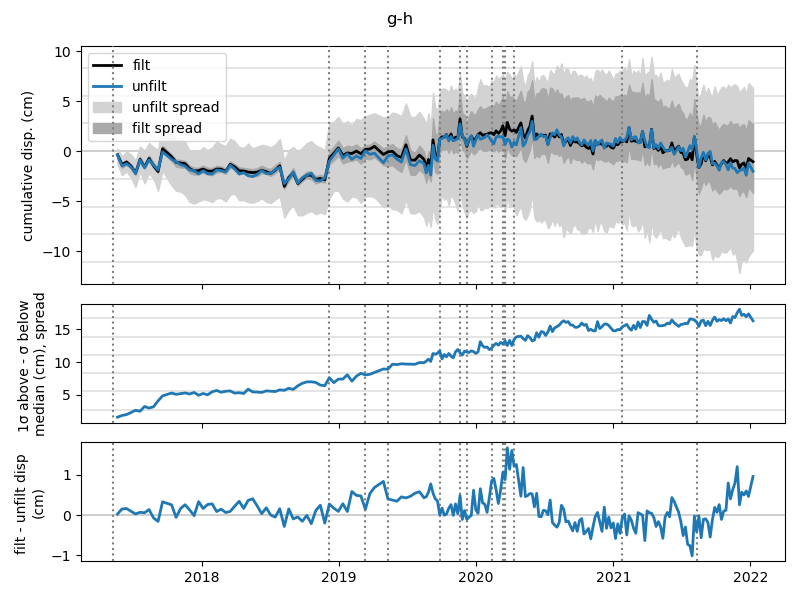

In [17]:
# plot everything in a single figure for presentation slides 
if key==0:
    color_to_use = 'purple'; title_text = 'a-b'
elif key==1:
    color_to_use = 'tab:orange'; title_text = 'c-d'
elif key==2:
    color_to_use = 'tab:green'; title_text = 'e-f'
elif key==3:
    color_to_use = 'tab:blue'; title_text = 'g-h'

#plt.figure()
plt.subplots(3,1,sharex=True,figsize=(8,6),tight_layout='TRUE',gridspec_kw={'height_ratios': [2,1,1]})


plt.subplot(3,1,1)
plt.plot(igram_dates,median_cum_filt_cm,color='k',linewidth=2,label='filt',zorder=15)
plt.plot(igram_dates,median_cum_cm,color=color_to_use,linewidth=2,label='unfilt',zorder=20) # purple,tab:orange,tab:green,tab:blue
plt.fill_between(igram_dates,lower_cum_cm,upper_cum_cm,color='lightgray',label='unfilt spread',zorder=5)
plt.fill_between(igram_dates,lower_cum_filt_cm,upper_cum_filt_cm,color='darkgray',label='filt spread',zorder=8)
Ymin,Ymax = plt.gca().get_ylim()
# calculate btw Ymin and Ymax where the 2pi rad multiples are
grid_multiples = []
count1 = 0
while (count1*twoPi_interval_cm < Ymax):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1+=1
count1 = 0
while (count1*twoPi_interval_cm > Ymin):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1-=1
#print(grid_multiples)
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=10)
Xmin,Xmax = plt.gca().get_xlim()
plt.hlines(grid_multiples,Xmin,Xmax,'gray',linewidth=0.3,zorder=0)
plt.ylim([Ymin,Ymax]); plt.xlim([Xmin,Xmax]); plt.legend(loc='upper left')
#plt.title('Cum. disp. btw sets of '+str(num_pixels)+' pixels (cm)')
plt.ylabel('cumulative disp. (cm)'); #plt.xlabel('date')
yval = -10.0
linewid = 6.0
# plt.hlines(yval,igram_dates[0],igram_dates[46],color='gold',linewidth=linewid,zorder=10)
# plt.hlines(yval,igram_dates[47],igram_dates[107],color='hotpink',linewidth=linewid,zorder=10)
# plt.hlines(yval,igram_dates[108],igram_dates[146],color='olive',linewidth=linewid,zorder=10)
# plt.hlines(yval,igram_dates[147],igram_dates[-1],color='coral',linewidth=linewid,zorder=10)
# plt.hlines(yval-1.0,igram_dates[0],igram_dates[88],color='cornflowerblue',linewidth=linewid,zorder=10)

plt.subplot(3,1,2)
plt.plot(igram_dates,upper_cum_cm-lower_cum_cm,color=color_to_use,linewidth=2,zorder=30) # purple,tab:orange,tab:green,tab:blue
Ymin,Ymax = plt.gca().get_ylim()
# calculate btw Ymin and Ymax where the 2pi rad multiples are
grid_multiples = []
count1 = 0
while (count1*twoPi_interval_cm < Ymax):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1+=1
count1 = 0
while (count1*twoPi_interval_cm > Ymin):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1-=1
#print(grid_multiples)
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=20)
Xmin,Xmax = plt.gca().get_xlim()
plt.hlines(grid_multiples,Xmin,Xmax,'gray',linewidth=0.3,zorder=0)
plt.ylim([Ymin,Ymax]); 
plt.xlim([Xmin,Xmax])
#plt.title('Cumulative disp. at '+str(num_pixels)+' pixels (rad/igram)')
plt.ylabel('1\u03C3 above - \u03C3 below \nmedian (cm), spread'); #plt.xlabel('date')

plt.subplot(3,1,3)
plt.plot(igram_dates,median_cum_filt_cm-median_cum_cm,color=color_to_use,linewidth=2,zorder=15)
Ymin,Ymax = plt.gca().get_ylim()
# calculate btw Ymin and Ymax where the 2pi rad multiples are
grid_multiples = []
count1 = 0
while (count1*twoPi_interval_cm < Ymax):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1+=1
count1 = 0
while (count1*twoPi_interval_cm > Ymin):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1-=1
#print(grid_multiples)
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=10)
Xmin,Xmax = plt.gca().get_xlim()
plt.hlines(grid_multiples,Xmin,Xmax,'gray',linewidth=0.3,zorder=0)
plt.ylim([Ymin,Ymax]); plt.xlim([Xmin,Xmax]);
#plt.title('Cum. disp. btw sets of '+str(num_pixels)+' pixels (cm)')
plt.ylabel('filt - unfilt disp \n(cm)')

plt.suptitle(title_text)

plt.show()
#plt.savefig("time_series_g-h_with_time_blocks.pdf", transparent=True)